In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

from satforecast.data import data
from satforecast.modeling.model_selection import rolling_batch
from satforecast.modeling.train import train

data.download()
image_dir = data.process_gs_rainfall_daily(scale=0.05)
image_files = data.get_files(image_dir, '*.npy')

In [2]:
import torch
import torch.nn as nn

class TransformerImagePrediction(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, output_dim):
        super(TransformerImagePrediction, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.output_dim = output_dim

        # Encoder
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=input_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim
            ),
            num_layers=num_layers
        )

        # Decoder
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=input_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim
            ),
            num_layers=num_layers
        )

        # Output layer
        self.fc = nn.Linear(hidden_dim * input_dim, output_dim)

    def forward(self, input_sequence):
        # input_sequence: Tensor of shape (batch_size, seq_len, n_channels, height, width)

        batch_size, seq_len, n_channels, height, width = input_sequence.size()

        # Reshape input sequence
        input_sequence = input_sequence.view(batch_size, seq_len, -1)

        # Encoding
        encoded_sequence = self.encoder(input_sequence)

        # Reshape encoded sequence
        encoded_sequence = encoded_sequence.view(batch_size * seq_len, -1)

        # Decoding
        output_sequence = self.decoder(encoded_sequence, encoded_sequence)

        # Reshape output sequence
        output_sequence = output_sequence.view(batch_size, seq_len, n_channels, height, width)

        # Prediction
        #print(output_sequence.shape)
        #prediction = self.fc(output_sequence[:, -1].view(batch_size, -1))  # Reshape before passing to linear layer

        return nn.ReLU(inplace=True)(output_sequence[:, -1])

    def predict(self, x):
        return self.forward(x)

Batch 0: Validation loss = 0.37408703565597534, Train time = 0.3, Update time = 4.4, Validation time = 0.3
Batch 1: Validation loss = 0.33529821038246155, Train time = 0.3, Update time = 3.9, Validation time = 0.4
Batch 2: Validation loss = 0.27767980098724365, Train time = 0.3, Update time = 3.4, Validation time = 0.2
Batch 3: Validation loss = 0.2293594777584076, Train time = 0.2, Update time = 3.1, Validation time = 0.3
Batch 4: Validation loss = 0.1990061104297638, Train time = 0.2, Update time = 3.2, Validation time = 0.2
Batch 5: Validation loss = 0.16925613582134247, Train time = 0.2, Update time = 3.2, Validation time = 0.2
Batch 6: Validation loss = 0.1548624336719513, Train time = 0.2, Update time = 3.1, Validation time = 0.2
Batch 7: Validation loss = 0.14080160856246948, Train time = 0.2, Update time = 3.2, Validation time = 0.3
Batch 0: Validation loss = 0.12624162435531616, Train time = 0.2, Update time = 3.1, Validation time = 0.3
Batch 1: Validation loss = 0.12671437859

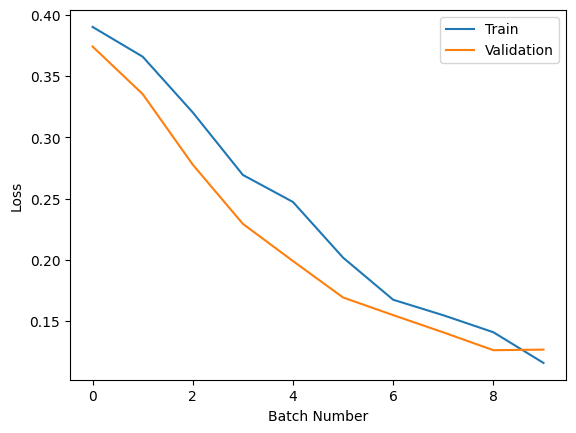

In [3]:
# Test train function
TEST_N_IMAGES = 100
test_image_files = image_files[:TEST_N_IMAGES]

input_dim = 1 * 30 * 90 # n_channels * height * width
hidden_dim = 64
num_layers = 4
num_heads = 6
output_dim = input_dim

test_tf = TransformerImagePrediction(input_dim, hidden_dim, num_layers, num_heads, output_dim)

train_loss, val_loss = train(
    model = test_tf,
    model_name = 'test_tf_v0',
    criterion = nn.MSELoss(),
    optimizer = torch.optim.Adam(test_tf.parameters()),
    files_list = test_image_files,
    train_frac = 0.6,
    val_frac = 0.1,
    seq_len = 5,
    batch_size = 2,
    max_epochs = 3,
    val_level = 'batch',
    early_stopping = True,
    min_improv = 0.001,
    max_iter_improv = 1,
    log_level = 1
)

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');

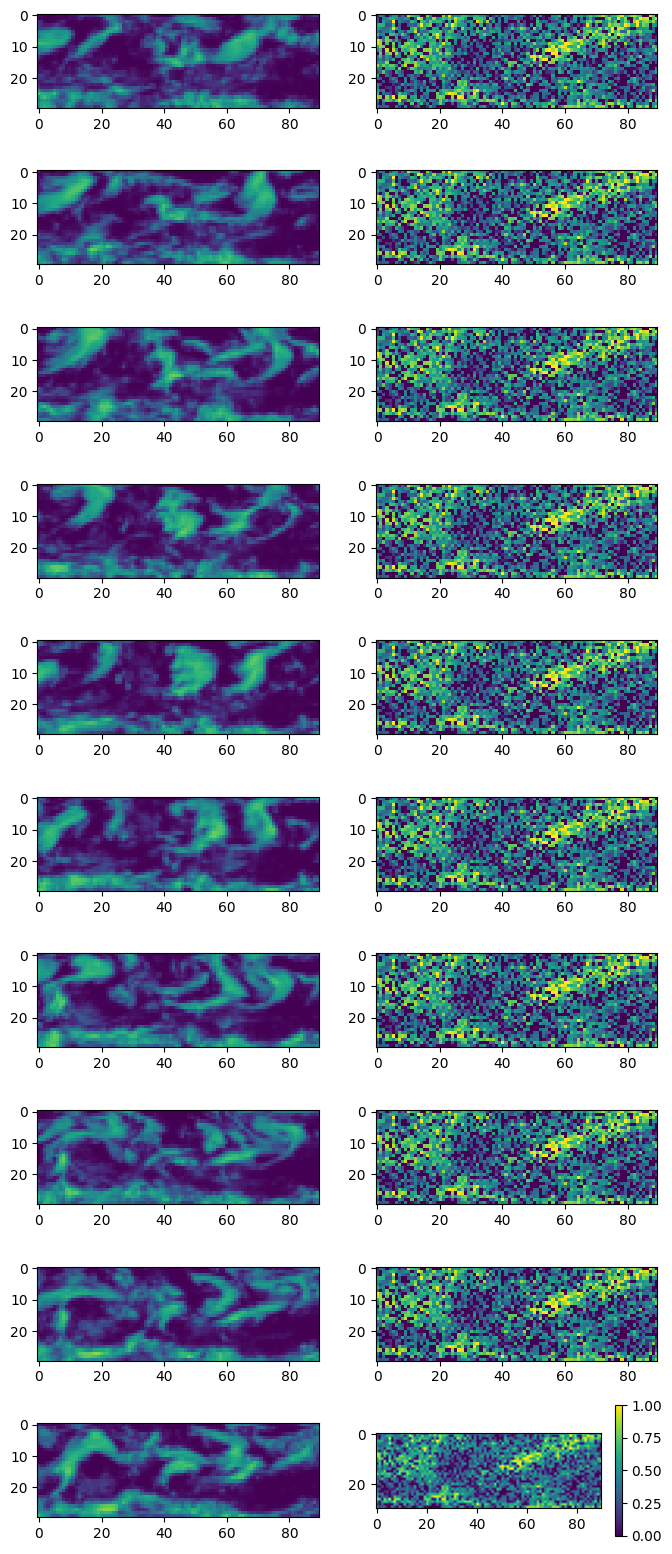

In [4]:
N_DAYS = 10
COLS = 2
IMAGE_SIZE = (30, 90)

fig, axs = plt.subplots(N_DAYS, COLS, figsize=(8, 2*N_DAYS))

test_tf.eval()

SEQ_LEN = 5
for i in range(N_DAYS):

    # Get predicted
    X, y = rolling_batch(image_files[TEST_N_IMAGES + i: TEST_N_IMAGES + i + SEQ_LEN + 1], start=0, stop=SEQ_LEN + 1, seq_len=SEQ_LEN)
    y = torch.reshape(y, IMAGE_SIZE).numpy()
    y_pred = torch.reshape(test_tf.predict(X), IMAGE_SIZE).detach().numpy()

    # Plot real
    plt.subplot(N_DAYS, COLS, i * COLS + 1)
    plt.imshow(y.astype('float32'), vmin=0, vmax=1)

    # Plot predicted
    plt.subplot(N_DAYS, COLS, i * COLS + 2)
    plt.imshow(y_pred.astype('float32'), vmin=0, vmax=1)

plt.colorbar();

In [5]:
del test_tf

## Semi-full training

Batch 0: Validation loss = 0.3695712685585022, Train time = 0.4, Update time = 5.1, Validation time = 3.3
Batch 1: Validation loss = 0.3034772276878357, Train time = 0.4, Update time = 3.4, Validation time = 2.8
Batch 2: Validation loss = 0.24463477730751038, Train time = 0.4, Update time = 3.1, Validation time = 2.7
Batch 3: Validation loss = 0.20326395332813263, Train time = 0.5, Update time = 3.2, Validation time = 3.2
Batch 4: Validation loss = 0.16871951520442963, Train time = 0.4, Update time = 3.2, Validation time = 3.4
Batch 5: Validation loss = 0.14922642707824707, Train time = 0.4, Update time = 3.4, Validation time = 3.9
Batch 6: Validation loss = 0.13127902150154114, Train time = 0.5, Update time = 3.3, Validation time = 3.3
Batch 7: Validation loss = 0.1162402406334877, Train time = 0.4, Update time = 3.3, Validation time = 3.2
Batch 8: Validation loss = 0.11287349462509155, Train time = 0.5, Update time = 3.7, Validation time = 3.9
Batch 9: Validation loss = 0.11189884692

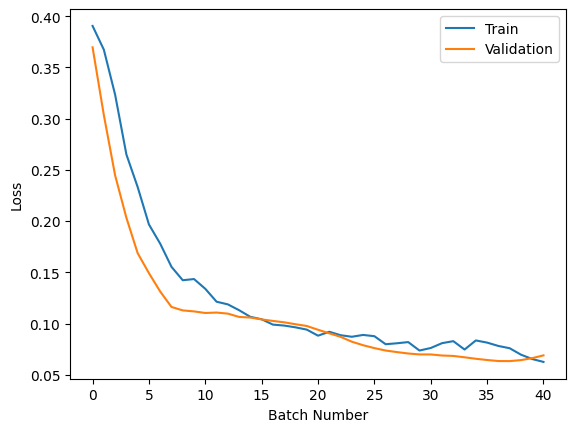

In [6]:
# Data constants
DEV_N_IMAGES = 2_000
TRAIN_FRAC = 0.7
VAL_FRAC = 0.05
SEQ_LEN = 5
BATCH_SIZE = 1

dev_image_files = image_files[:DEV_N_IMAGES]

# Model
input_dim = 1 * 30 * 90 # n_channels * height * width
hidden_dim = 64
num_layers = 4
num_heads = 6
output_dim = input_dim

dev_tf = TransformerImagePrediction(input_dim, hidden_dim, num_layers, num_heads, output_dim)
model_name = 'dev_tf_v0'
criterion = nn.MSELoss()
optim = torch.optim.Adam(dev_tf.parameters())

# Training constants
BATCH_SIZE = 10
MAX_EPOCHS = 3
MIN_IMPROV = 0.000
MAX_ITER_IMPROV = 3

train_loss, val_loss = train(
    model = dev_tf,
    model_name = model_name,
    criterion = criterion,
    optimizer = optim,
    files_list = dev_image_files,
    train_frac = TRAIN_FRAC,
    val_frac = VAL_FRAC,
    seq_len = SEQ_LEN,
    batch_size = BATCH_SIZE,
    max_epochs = MAX_EPOCHS,
    val_level = 'batch',
    early_stopping = True,
    min_improv = MIN_IMPROV,
    max_iter_improv = MAX_ITER_IMPROV,
    log_level = 1
)

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');

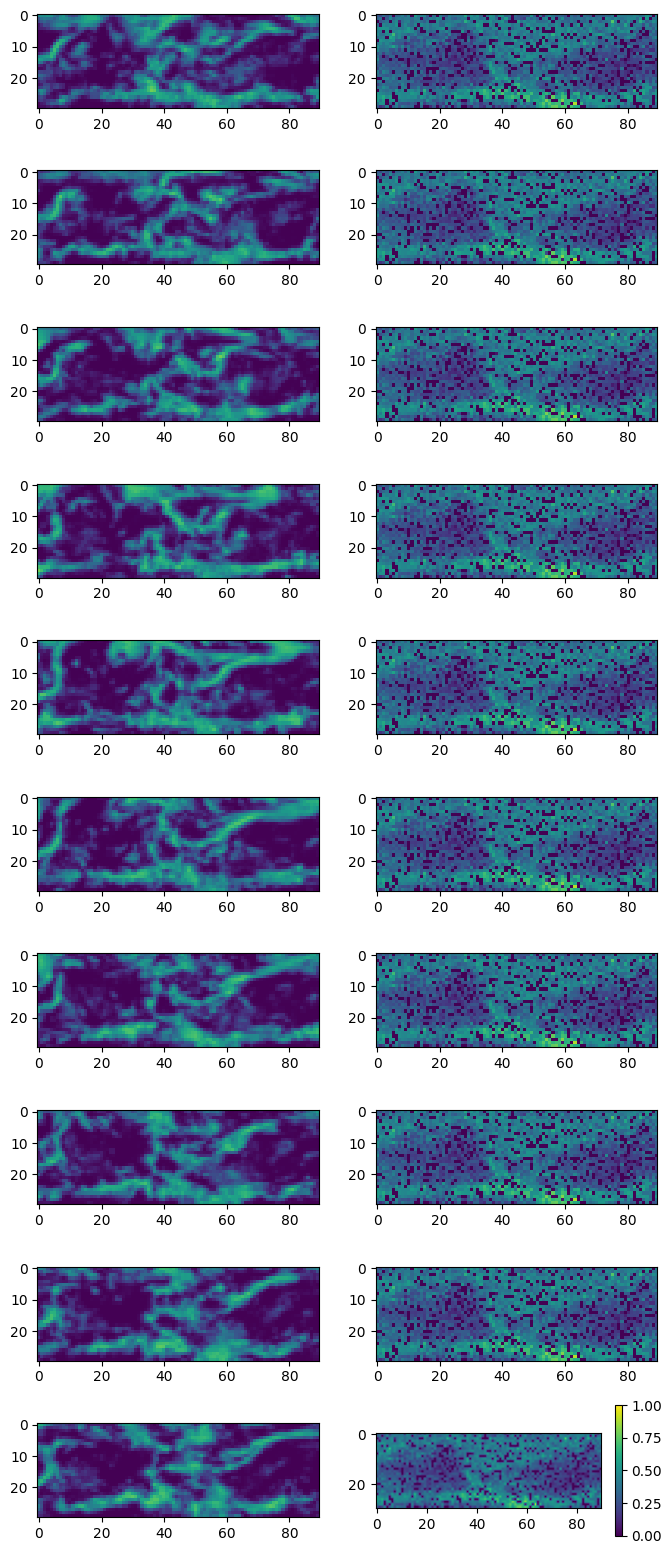

In [8]:
N_DAYS = 10
COLS = 2
IMAGE_SIZE = (30, 90)

fig, axs = plt.subplots(N_DAYS, COLS, figsize=(8, 2*N_DAYS))

dev_tf.eval()

for i in range(N_DAYS):

    # Get predicted
    X, y = rolling_batch(image_files[DEV_N_IMAGES + i: DEV_N_IMAGES + i + SEQ_LEN + 1], start=0, stop=SEQ_LEN + 1, seq_len=SEQ_LEN)
    y = torch.reshape(y, IMAGE_SIZE).numpy()
    y_pred = torch.reshape(dev_tf.predict(X), IMAGE_SIZE).detach().numpy()

    # Plot real
    plt.subplot(N_DAYS, COLS, i * COLS + 1)
    plt.imshow(y.astype('float32'), vmin=0, vmax=1)

    # Plot predicted
    plt.subplot(N_DAYS, COLS, i * COLS + 2)
    plt.imshow(y_pred.astype('float32'), vmin=0, vmax=1)

plt.colorbar();